### Capstone Submission: Replicate Research Paper
Created December 27, 2021

Original code : https://github.com/xuebinqin/U-2-Net 
<P>
Original paper: http://arxiv.org/abs/2005.09007

U2-Net is based on U-Net (http://www.cs.cmu.edu/~jeanoh/16-785/papers/ronnenberger-miccai2015-u-net.pdf), a convolutional neural network developed for biological image segmentation. 
<P> 
While U2-Net is not specifically for clothing segmentation, there are public projects applying the model for said applications.
<P> 
In this notebook, we will apply the model developed by U2-Net for basic segmentation. As the capstone project will explore model development (along with other components of the architectual pipeline), we will not be training the model yet - only loading the trained model and testing it. 

In [3]:
import os
from skimage import io, transform
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.transforms as transforms
# import torch.optim as optim

In [4]:
torch.__version__

'1.11.0.dev20211231'

In [5]:
import numpy as np
from PIL import Image
import glob
import sys

sys.path.append('/Users/narekgeghamyan/Classes/MLE_bootcamp/U-2-Net')
from data_loader import RescaleT
from data_loader import ToTensor
from data_loader import ToTensorLab
from data_loader import SalObjDataset

# from model import U2NET # full size version 173.6 MB
from model import U2NETP # small version u2net 4.7 MB

In [34]:
import matplotlib.pyplot as plt

In [6]:
# normalize the predicted SOD probability map
def normPRED(d):
    ma = torch.max(d)
    mi = torch.min(d)

    dn = (d-mi)/(ma-mi)

    return dn

In [36]:
def save_output(image_name,pred,p_dir, source_dir):

    predict = pred
    predict = predict.squeeze()
    predict_np = predict.cpu().data.numpy()

    im = Image.fromarray(predict_np*255).convert('RGB')
    img_name = image_name.split(os.sep)[-1]
    image = io.imread(source_dir + image_name)
    imo = im.resize((image.shape[1],image.shape[0]),resample=Image.BILINEAR)
    plt.imshow(imo)
    plt.show()

#     pb_np = np.array(imo)

#     aaa = img_name.split(".")
#     bbb = aaa[0:-1]
#     imidx = bbb[0]
#     for i in range(1,len(bbb)):
#         imidx = imidx + "." + bbb[i]

#     imo.save(d_dir+imidx+'.png')
    imo.save(p_dir+image_name)

In [27]:
# --------- 1. get image path and name ---------
model_name='u2netp'#u2net


image_dir = '/Users/narekgeghamyan/Classes/MLE_bootcamp/U-2-Net/test_data/test_images/'
# prediction_dir = os.path.join(model_dir, 'test_data', model_name + '_results' + os.sep)
prediction_dir = '/Users/narekgeghamyan/Classes/MLE_bootcamp/U-2-Net/test_data/u2netp_results/'
# model_dir = os.path.join(model_dir, 'saved_models', model_name, model_name + '.pth')
model_dir = '/Users/narekgeghamyan/Classes/MLE_bootcamp/U-2-Net/saved_models/u2netp/u2netp.pth'

img_name_list = glob.glob(image_dir + os.sep + '*')
print(img_name_list)

['/Users/narekgeghamyan/Classes/MLE_bootcamp/U-2-Net/test_data/test_images/horse.jpg', '/Users/narekgeghamyan/Classes/MLE_bootcamp/U-2-Net/test_data/test_images/boat.jpg', '/Users/narekgeghamyan/Classes/MLE_bootcamp/U-2-Net/test_data/test_images/0002-01.jpg', '/Users/narekgeghamyan/Classes/MLE_bootcamp/U-2-Net/test_data/test_images/im_21.png', '/Users/narekgeghamyan/Classes/MLE_bootcamp/U-2-Net/test_data/test_images/bike.jpg', '/Users/narekgeghamyan/Classes/MLE_bootcamp/U-2-Net/test_data/test_images/girl.png', '/Users/narekgeghamyan/Classes/MLE_bootcamp/U-2-Net/test_data/test_images/im_27.png', '/Users/narekgeghamyan/Classes/MLE_bootcamp/U-2-Net/test_data/test_images/whisk.png', '/Users/narekgeghamyan/Classes/MLE_bootcamp/U-2-Net/test_data/test_images/0003.jpg', '/Users/narekgeghamyan/Classes/MLE_bootcamp/U-2-Net/test_data/test_images/lamp2_meitu_1.jpg', '/Users/narekgeghamyan/Classes/MLE_bootcamp/U-2-Net/test_data/test_images/vangogh.jpeg', '/Users/narekgeghamyan/Classes/MLE_bootcamp/

In [9]:
# --------- 2. dataloader ---------
test_salobj_dataset = SalObjDataset(img_name_list = img_name_list,
                                    lbl_name_list = [],
                                    transform=transforms.Compose([RescaleT(320),
                                                                  ToTensorLab(flag=0)])
                                    )

# test_salobj_dataset = SalObjDataset(img_name_list = img_name_list,
#                                     lbl_name_list = [],
#                                     transform=320)

test_salobj_dataloader = DataLoader(test_salobj_dataset,
                                    batch_size=1,
                                    shuffle=False,
                                    num_workers=1)

In [10]:
# --------- 3. model define ---------
if(model_name=='u2net'):
    print("...load U2NET---173.6 MB")
    net = U2NET(3,1)
elif(model_name=='u2netp'):
    print("...load U2NEP---4.7 MB")
    net = U2NETP(3,1)

if torch.cuda.is_available():
    net.load_state_dict(torch.load(model_dir))
    net.cuda()
else:
    net.load_state_dict(torch.load(model_dir, map_location='cpu'))
net.eval()

...load U2NEP---4.7 MB


U2NETP(
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv3): REBNCONV(
      (conv_s1): Conv2d(16, 16, 

inferencing: horse.jpg


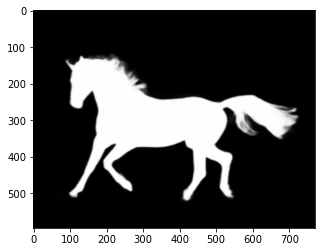

inferencing: boat.jpg


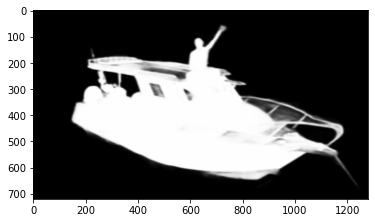

inferencing: 0002-01.jpg


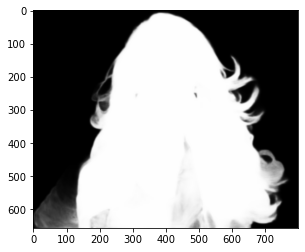

inferencing: im_21.png


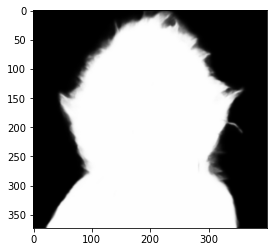

inferencing: bike.jpg


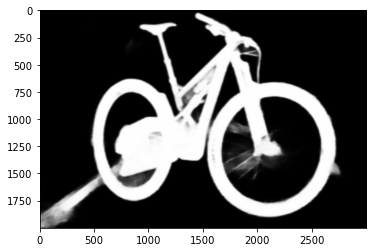

inferencing: girl.png


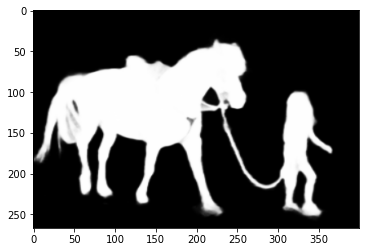

In [ ]:
# --------- 4. inference for each image ---------
for i_test, data_test in enumerate(test_salobj_dataloader):

    img_file_name = img_name_list[i_test].split(os.sep)[-1]
    print("inferencing:",img_file_name)

    inputs_test = data_test['image']
    inputs_test = inputs_test.type(torch.FloatTensor)

    if torch.cuda.is_available():
        inputs_test = Variable(inputs_test.cuda())
    else:
        inputs_test = Variable(inputs_test)

    d1,d2,d3,d4,d5,d6,d7= net(inputs_test)

    # normalization
    pred = d1[:,0,:,:]
    pred = normPRED(pred)

    # save results to test_results folder
    if not os.path.exists(prediction_dir):
        os.makedirs(prediction_dir, exist_ok=True)
#     save_output(img_name_list[i_test],pred,prediction_dir)
    save_output(img_file_name, pred, prediction_dir, image_dir)
    
    del d1,d2,d3,d4,d5,d6,d7